### Accessing Dataset From Google Drive 

Mounting GDrive and specifying path for the same

In [ ]:
from pathlib import Path
import os
import numpy as np
from google.colab import drive

drive.mount('/content/gdrive')
path = Path("/content/gdrive/My Drive/Colab Notebooks/datasetimg/Google Images/train")

In [2]:
data_list = os.listdir(path)
data_list

['Burj Khalifa - UAE',
 'Eiffel Tower - Paris',
 'Machu Pichu',
 'Great Wall Of China - China',
 'Himalaya - India',
 'Christ the Reedemer Statue',
 'Chich-n Itz - Mexico',
 'Antarctica',
 'Giant-s Causeway',
 'The Blue Grotto - Capri',
 'Stonehenge',
 'Niagara Falls',
 'Taj Mahal - India',
 'Pyramids Of Giza - Egypt',
 'Venezuela Angel Falls',
 'Santorini',
 'Roman Colosseum - Rome',
 'Statue Of Liberty - NYC']

In [3]:
data_list.sort()
print(data_list)

['Antarctica', 'Burj Khalifa - UAE', 'Chich-n Itz - Mexico', 'Christ the Reedemer Statue', 'Eiffel Tower - Paris', 'Giant-s Causeway', 'Great Wall Of China - China', 'Himalaya - India', 'Machu Pichu', 'Niagara Falls', 'Pyramids Of Giza - Egypt', 'Roman Colosseum - Rome', 'Santorini', 'Statue Of Liberty - NYC', 'Stonehenge', 'Taj Mahal - India', 'The Blue Grotto - Capri', 'Venezuela Angel Falls']


In [4]:
import cv2
import glob
import tensorflow as tf
from scipy.misc import *
from tqdm import tqdm
from PIL import Image
from numpy import*
data=[]

Convert all images into gray scale array values 

In [5]:
for category in data_list:
    path_ = os.path.join(path,category)
    for img in tqdm(os.listdir(path_)):
        img_array = cv2.imread(os.path.join(path_,img) ,cv2.IMREAD_GRAYSCALE)
        data.append([img_array,category])

100%|██████████| 138/138 [00:43<00:00,  2.96it/s]


Now data is in same repetitive pattern model will mislead its learning due this, hence shuffle data to avoid any circumstance

In [0]:
import random

random.shuffle(data)

Seperating feature and label 

In [ ]:
features = []
labels = []

for feat,label in data:
    features.append(feat)
    labels.append(label)

Using label encoder to convert categorical data into numerical 

In [8]:
from sklearn import preprocessing 
label=[]
label = np.asarray(labels)
labels=[] 
label_encoder = preprocessing.LabelEncoder() 
labels= label_encoder.fit_transform(label)

print(labels[:30])

[ 4 12 12 11 12 15 16  6 14 10 17  6 16  7  0  8  6  2 15  7 14  8 11 13
  6  5  5  8  4 10]


Image size may vary so resize image into 250 X 250 

In [0]:
img_array=[]
i=[]
width = 250
height = 250
for i in features:
    resized = cv2.resize(i,(width,height), interpolation=cv2.INTER_CUBIC)
    img_array.append(resized)

Reshaping

In [0]:
img_array = np.asarray(img_array)
img_array = img_array.reshape(len(img_array),250,250,1)

Let's save the structure of model till now in pickle

In [0]:
import pickle
x = open("feat.pickle","wb")
pickle.dump(img_array, x)
x.close()

Y = open("label.pickle","wb")
pickle.dump(labels, Y)
Y.close()

Open dumped pickle file

In [0]:
import pickle
pickle_in = open("feat.pickle","rb")
feature = pickle.load(pickle_in)

pickle_in = open("label.pickle","rb")
label = pickle.load(pickle_in)

[Rescale images](https://datascience.stackexchange.com/questions/29958/when-inputting-image-rgb-values-to-mlp-should-i-divide-by-255)

In [0]:
feature = img_array/255.0

Splitting features and label into training and validation set 

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(feature, labels , test_size = 0.2, random_state=42)

In [0]:

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10, # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally 
        height_shift_range=0.1,  # randomly shift images vertically 
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)  # fitting X_train 

In [16]:

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D

model = Sequential()

model.add(Conv2D(180,kernel_size=(3,3),activation='relu',input_shape=(250,250,1)))
model.add(Conv2D(150,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(5,5))
model.add(Dropout(rate=0.3))   
model.add(Conv2D(110,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(5,5))
model.add(Conv2D(80,kernel_size=(3,3),activation='relu'))
model.add(Flatten())
model.add(Dense(80,activation='relu'))
model.add(Dense(60,activation='relu'))
model.add(Dropout(rate=0.3))
model.add(Dense(45,activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(18,activation='softmax'))

model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


ReduceLROnPlateau provide feature of updating learning rate whenever training score is not progressing forward

In [0]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',   # quality to be monitored 
                                            patience=3,          # no improvement after learning rate will be reduced
                                            verbose=1,           # update message
                                            factor=0.5,          # reducing learning rate 
                                            min_lr=0.000005)      # learning rate

In [24]:
fitting = model.fit_generator(datagen.flow(X_train, Y_train, batch_size = 45),
                              epochs = 30, validation_data = (X_val, Y_val),
                              verbose = 1, callbacks = [learning_rate_reduction])

Epoch 1/30
52/52 [==============================] - 129s 2s/step - loss: 2.8121 - acc: 0.1110 - val_loss: 2.7500 - val_acc: 0.1357
Epoch 2/30
52/52 [==============================] - 129s 2s/step - loss: 2.8200 - acc: 0.1136 - val_loss: 2.7199 - val_acc: 0.1409
Epoch 3/30
52/52 [==============================] - 129s 2s/step - loss: 2.7381 - acc: 0.1545 - val_loss: 2.6842 - val_acc: 0.1600
Epoch 4/30
52/52 [==============================] - 129s 2s/step - loss: 2.6598 - acc: 0.1672 - val_loss: 2.6016 - val_acc: 0.1687
Epoch 5/30
52/52 [==============================] - 130s 2s/step - loss: 2.6713 - acc: 0.1711 - val_loss: 2.5059 - val_acc: 0.2209
Epoch 6/30
52/52 [==============================] - 129s 2s/step - loss: 2.5307 - acc: 0.2024 - val_loss: 2.4129 - val_acc: 0.2296
Epoch 7/30
52/52 [==============================] - 129s 2s/step - loss: 2.4763 - acc: 0.2212 - val_loss: 2.3686 - val_acc: 0.2417
Epoch 8/30
52/52 [==============================] - 129s 2s/step - loss: 2.4209 - a

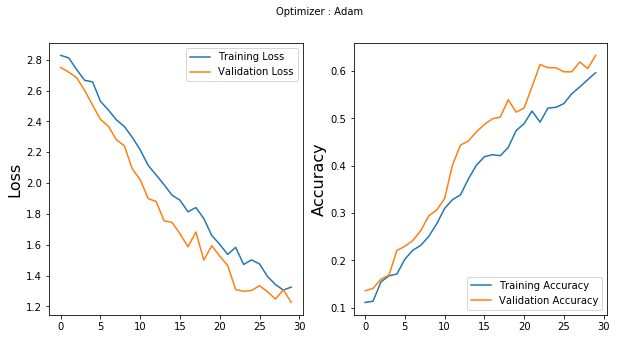

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(fitting.history['loss'], label='Training Loss')
plt.plot(fitting.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(fitting.history['acc'], label='Training Accuracy')
plt.plot(fitting.history['val_acc'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()